In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Arrival & service rates
A = 20            # calls per hour
u = 5             # calls served per agent per hour
shift_hours = 8   # 8-hour shift

# Simulate settings
np.random.seed(1)

In [3]:
# 2. Single-Run Simulation Function

def simulate_queue(s):
    """
    Simulate an M/M/s queue over 'shift_hours'.
    Returns arrays of wait times (hrs) and system sizes at arrivals.
    """

    # generate arrival times until end of shift
    inter = np.random.exponential(1/A, int(A*shift_hours*1.5))
    arrivals = np.cumsum(inter)
    arrivals = arrivals[arrivals < shift_hours]
    N = len(arrivals)

    # generate service times for each caller
    services = np.random.exponential(1/u, N)

    # track each server's next-free time
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)

    # departure times list
    dep_times = []

    for i, t in enumerate(arrivals):
        # find soonest-available agent
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + services[i]
        next_free[j] = end
        dep_times.append(end)

        # count how many callers are still in system at time t
        system_size[i] = np.sum(np.array(dep_times) > t)

    return wait_times, system_size


  # quick test for s=1
w1, q1 = simulate_queue(s=1)
print(f"s=1: avg wait {w1.mean()*60:.1f} min, avg queue len {q1.mean():.2f}")

s=1: avg wait 808.2 min, avg queue len 65.99


In [4]:
# 3. Compare to M/M/1 Analytic Formula

# traffic intensity ρ for s=1
ρ1 = A / u
L_analytic = ρ1 / (1 - ρ1)
W_analytic = L_analytic / A  # hours

print("M/M/1 analytic vs. simulation:")
print(f"  Analytic system size L = {L_analytic:.2f}")
print(f"  Simulated avg system size = {q1.mean():.2f}")
print(f"  Analytic time in system W = {W_analytic*60:.1f} min")
print(f"  Simulated avg wait+service = {(w1.mean() + (1/u))*60:.1f} min")

M/M/1 analytic vs. simulation:
  Analytic system size L = -1.33
  Simulated avg system size = 65.99
  Analytic time in system W = -4.0 min
  Simulated avg wait+service = 820.2 min


In [10]:
threshold = 5  # minutes
results = []

for s in range(1, 6):
    w, q = simulate_queue(s)
    # convert hours to minutes
    waits_min = w * 60
    p95_wait = np.percentile(waits_min, 95)
    results.append((s, waits_min.mean(), p95_wait, q.mean()))

# tabulate
import pandas as pd
df = pd.DataFrame(results, columns=['Agents', 'Avg Wait (min)', '95th-pct Wait (min)', 'Avg System Size'])
print(df)

# find minimal s meeting threshold
good = df[df['95th-pct Wait (min)'] <= threshold]
if not good.empty:
    best_s = int(good.iloc[0]['Agents'])
    print(f"\n=> Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
    print(f"\nEven 5 agents can't meet the 5 min 95% wait target.")

   Agents  Avg Wait (min)  95th-pct Wait (min)  Avg System Size
0       1      703.341351          1416.054966        62.359281
1       2      210.291373           454.050946        34.025000
2       3       55.355851            81.837651        19.697987
3       4        9.673012            27.274922         7.361111
4       5        5.092534            21.376076         6.613924

Even 5 agents can't meet the 5 min 95% wait target.


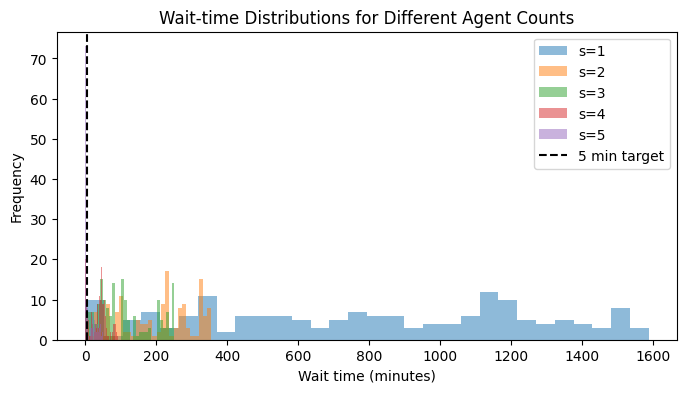

In [11]:
# 5. Visualize Wait-Time Distributions
plt.figure(figsize=(8, 4))
for s in [1, 2, 3, 4, 5]:
    w, _ = simulate_queue(s)
    plt.hist(w * 60, bins=30, alpha=0.5, label=f's={s}')

plt.axvline(threshold, color='k', linestyle='--', label='5 min target')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait-time Distributions for Different Agent Counts')
plt.legend()
plt.show()

In [13]:
# 6. Time-Varying λ
def simulate_queue_timevarying(s):
    # define piecewise arrival rates per hour
    periods = [(0,2,30), (2,6,20), (6,8,40)]  # (start, end, λ)
    arrivals = []
    for start, end, lam in periods:
        duration = end - start
        inter = np.random.exponential(1/lam, int(lam*duration*1.5))
        ts = np.cumsum(inter) + start
        arrivals.extend(ts[ts < end])
    arrivals = np.array(arrivals)
    arrivals.sort()

    N = len(arrivals)
    services = np.random.exponential(1/u, N)
    next_free = np.zeros(s)
    wait_times = np.zeros(N)

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        next_free[j] = start + services[i]

    return wait_times
w_tv = simulate_queue_timevarying(s=3)
print(f"Time-varying λ, s=3 → avg wait = {w_tv.mean()*60:.1f} min")

#**outcome:** student will see how peak-hour traffic dramatically
#increase wait times unless staff levels raise.

Time-varying λ, s=3 → avg wait = 183.4 min


In [17]:
# 7. Abandonment
def simulate_with_abandon(s, patience=5/60):
    arrivals = np.cumsum(np.random.exponential(1/A, int(A*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/u, len(arrivals))
    next_free = np.zeros(s)
    waits = []
    abandons = 0

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait = start - t
        if wait > patience:
            abandons += 1
        else:
            waits.append(wait)
            next_free[j] = start + services[i]

    return np.array(waits), abandons / len(arrivals)
w, ab_rate = simulate_with_abandon(s=4)
print(f"Abandon rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")

Abandon rate (s=4): 21.77%, avg wait on served calls: 0.9 min


In [20]:
# 8. Agent Break Scheduling
def simulate_with_breaks(s, break_start=3, break_length=0.25):
    arrivals = np.cumsum(np.random.exponential(1/A, int(A*shift_hours*1.5)))
    arrivals = arrivals[arrivals < shift_hours]
    services = np.random.exponential(1/u, len(arrivals))
    next_free = np.zeros(s)
    waits = []

    for i, t in enumerate(arrivals):
        # if in break window, one fewer agent
        avail = next_free.copy()
        if break_start < t < break_start + break_length:
            avail = np.delete(avail, 0)  # remove one agent
        j = np.argmin(avail)
        start = max(t, avail[j])
        waits.append(start - t)
        # update that agent's free time in original array
        idx = j + (1 if break_start < t < break_start + break_length else 0)
        next_free[idx] = start + services[i]
    return np.array(waits)
w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3 → avg wait = {w_b.mean()*60:.1f} min")

# see the "brake-time spike" in waiting

With breaks, s=3 → avg wait = 105.9 min


In [21]:
# 9. Cost optimization
c_agent = 20     # $20/hr per agent
c_wait = 0.50    # $0.50 per minute waited

costs = []
for s in range(1, 6):
    w, _ = simulate_with_abandon(s)  # or choose another sim fn
    total_wait_cost = w.sum() * 60 * c_wait
    staff_cost = s * c_agent * shift_hours
    costs.append((s, staff_cost + total_wait_cost))

opt = min(costs, key=lambda x: x[1])
print("Agent count, total cost:")
for s, c in costs: print(f" s={s}: ${c:,.0f}")
print(f"→ Optimal s by cost = {opt[0]}")

Agent count, total cost:
 s=1: $195
 s=2: $394
 s=3: $567
 s=4: $724
 s=5: $869
→ Optimal s by cost = 1


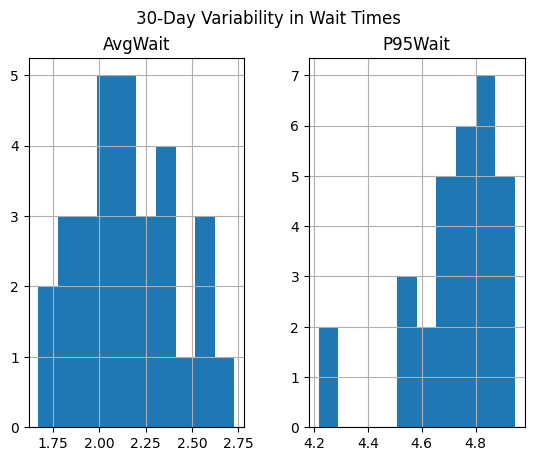

In [22]:
# 10. 30-day simulation
days = 30
daily = []
for _ in range(days):
    w, _ = simulate_with_abandon(opt[0])
    daily.append((w.mean()*60, np.percentile(w*60, 95)))

df_days = pd.DataFrame(daily, columns=['AvgWait', 'P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30-Day Variability in Wait Times')
plt.show()